# Pyro Crash Course – Notebook 6: Detecting Faulty Devices with Discrete Latents

This notebook introduces **discrete latent variables** into our probabilistic model. We classify each sensor as either **faulty or functioning** based on its measurements, extending the hierarchical Bayesian model from Notebook 5.

---

### 🔙 Quick Recap

*Notebook 5* gave each sensor its own offset and scale, inferred from data using variational inference. Now we assume **most sensors are good**, but a few might be **faulty** — with abnormally uncertain parameters.

We model this using a **latent binary switch `is_faulty` per device**, controlling which prior distribution the sensor’s parameters (`alpha`) are drawn from.

---

### 🎯 Learning Goals

- Introduce **discrete latent variables** and their use for classification
- Learn to model **qualitatively different behaviors** (e.g., normal vs. faulty sensors)
- Use **enumeration-based inference** (`TraceEnum_ELBO`) to marginalize over discrete variables
- Diagnose outliers by inspecting **posterior probabilities** over `is_faulty`
- Maintain structured calibration with **per-device posterior distributions**

---

### 🛠 Modeling Idea

Each device is assumed to be either:
- ✅ **Functioning normally**: parameters drawn from `N([0, 1], Σ)`
- ❌ **Faulty**: parameters drawn from `N([0, 1], Σ_faulty)` with much larger variance

The binary latent `is_faulty ∈ {0, 1}` is drawn from a Bernoulli prior with small `p_faulty`.   It controls whether the model treats the device as uncertain or reliable. This latent variable is inferred jointly with the usual offset and scale, and allows posterior classification after training.


For this, do the following:
   1. Imports and definitions  
   2. Build model and guide  
   3. Perform inference  
   4. Interpretations and illustrations


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/atlasoptimization/tutorials/blob/master/pyro/pyro_crash_course/pyro_cc_6_model_4.ipynb
)

> ⚠️ You do *not* need to sign in with GitHub to run this notebook.  
> Just click the Colab badge and start executing.

📎 Input: `sensor_measurements.csv` (generated in `pyro_cc_1_hello_dataset`) 

📌 Next: `pyro_cc_7_model_5` introduces some nonlinear trend on top of what we build here. That one will be the last tutorial of this crash course!


This notebook and series are created for educational purposes by  [Dr. Jemil Avers Butt, Atlas Optimization GmbH](https://www.atlasoptimization.com).


---

# Start of Notebook 6

## 1. Imports and definitions

We now need to import the decorator @config_enumerate from pyro.infer. That decorator marks all discrete latents in model and guide for complete enumeration. This is necessary for inference with TraceEnum_ELBO, the corresponding ELBO loss function in the presence of discrete latent variables.


📌 This is the first notebook that **introduces per-device latent variables**.


In [1]:
"""
    1. Imports and definitions
"""


# i) Imports
# If you run this in Colab, you might get an import error as pyro is not
# installed by default. In that case, uncomment the following command.
# !pip install pyro-ppl

# We need an additional decoration config_enumerate to declare inference over
# a discrete latent variable - then the appropriate sample sites are automatically
# exxhaustively enumerated.
import pyro
import torch
import pandas
import matplotlib.pyplot as plt
from pyro.infer import config_enumerate


# ii) Definitions
!wget https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
measurement_df = pandas.read_csv("sensor_measurements.csv")
n_device = measurement_df["sensor_id"].nunique()
n_measure = measurement_df["time_step"].nunique()

# Read out T_true and T_meas: the true temperature and the measured temperature
T_true = torch.tensor(measurement_df["T_true"].values).reshape(n_device, n_measure)
T_meas = torch.tensor(measurement_df["T_measured"].values).reshape(n_device, n_measure)

# Assume standard deviation
sigma_T_meas = 0.3

# Fix random seed
pyro.set_rng_seed(0)


--2025-05-09 16:40:37--  https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12270 (12K) [text/plain]
Saving to: ‘sensor_measurements.csv.3’

sensor_measurements 100%[===================>]  11.98K  --.-KB/s    in 0.07s   

2025-05-09 16:40:39 (184 KB/s) - ‘sensor_measurements.csv.3’ saved [12270/12270]



---

# 2. Build model and guide

## 🔧 Model Specification

We assume each sensor can be either:

- **Functioning normally**: Parameters drawn from `N([0, 1], Σ)`
- **Faulty**: Parameters drawn from `N([0, 1], Σ_faulty)` with much larger variance

Each device gets its own binary latent variable `is_faulty ~ Bernoulli(p_faulty)`.  
The device’s calibration parameters `alpha = (offset, scale)` are drawn from a prior that depends on whether it is faulty:

$$
\Sigma_{\text{device}} = \Sigma_{\text{normal}} + \text{is_faulty} \cdot (\Sigma_{\text{faulty}} - \Sigma_{\text{normal}})
$$

$$
\alpha_i \sim \mathcal{N}(\mu_\alpha, \Sigma_{\text{device},i})
\quad\text{with}\quad
\mu_\alpha = \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$

The measurement model is unchanged:

$$
T_{\text{meas}}[i, j] \sim \mathcal{N}(\alpha_{i,0} + \alpha_{i,1} \cdot T_{\text{true}}[i, j], \sigma_{\text{Tmeas}})
$$


In [2]:
"""
    2. Build model and guide
"""

# i) Define the model
# We implement the same model as in the previous notebook but add an additional
# generative step in the beginning, where we sample from the device production
# distribution to determine if the device is being produced faulty.

# Define priors and fixed params
mu_alpha = torch.tensor([0.0, 1.0]).expand(n_device, -1)
Sigma_alpha = torch.tensor([[0.1**2,0], [0, 0.1**2]])
p_faulty = 0.05
Sigma_faulty = 100*Sigma_alpha

# Build the model in pyro; use decorator to mark discrete variables for enumeration.
@config_enumerate
def model(input_vars = T_true, observations = None):
    # Build reusable independence context device_plate.
    device_plate = pyro.plate('device_plate', size=n_device, dim=-1)

    with device_plate:
        is_faulty = pyro.sample('is_faulty', pyro.distributions.Bernoulli(p_faulty))

    # Convert boolean indicator to tensor of shape [n_device, 1, 1] for broadcasting
    is_faulty_tensor = is_faulty.unsqueeze(-1).unsqueeze(-1)

    # Build Sigma_device via interpolation
    Sigma_device = Sigma_alpha + is_faulty_tensor * (Sigma_faulty - Sigma_alpha)  # shape: [n_device, 2, 2]

    # Make alpha_dist have a sigma dependent on  device and is_faulty
    alpha_dist = pyro.distributions.MultivariateNormal(
        loc=mu_alpha,                   # shape: [2, n_device, 2]
        covariance_matrix=Sigma_device)     # shape: [2, n_device, 2, 2]
            
    # Independence in first dim of alpha_dist, sample n_device times
    with device_plate:
        alpha = pyro.sample("alpha", alpha_dist)
    mean_obs = alpha[:, 0].unsqueeze(1) + alpha[:, 1].unsqueeze(1) * T_true
    obs_dist = pyro.distributions.Normal(loc=mean_obs, scale=sigma_T_meas)

    # Sample from this distribution and declare the samples independent in the
    with pyro.plate('device_plate', dim=-2):
        with pyro.plate('measure_plate', dim=-1):
            pyro.sample("observations", obs_dist, obs=observations)


## 🧭 Guide Construction

We use again **variational approximations** over the latent variables:

- A learnable Bernoulli posterior for `is_faulty`, with device-specific probabilities $\pi_i$
- A multivariate Gaussian posterior for each device’s calibration parameters

$$
q_\phi(\alpha_i, \text{is_faulty}_i) = 
\text{Bernoulli}(\pi_i) \cdot 
\mathcal{N}(\mu_{\alpha,i}, \Sigma_{\alpha,i})
$$

Both $\pi_i$ and the parameters of the Gaussian are trained during inference.

Enumerating `is_faulty` is handled automatically using `@config_enumerate` and `TraceEnum_ELBO`.


In [3]:
# ii) Build the guide
# Since the guide needs to encode the posterior distribution of the is_faulty
# variable now as well, we build a distribution with trainable parameters. 

# Build the guide
@config_enumerate
def guide(input_vars = T_true, observations = None):
    # Build reusable independence context device_plate.
    device_plate = pyro.plate('device_plate', size=n_device, dim=-1)
    
    # Learn a per-device probability of being faulty
    probs_faulty = pyro.param("probs_faulty", 0.05 * torch.ones(n_device),
                              constraint=pyro.distributions.constraints.unit_interval)
    
    # Sample discrete variable from learned probabilities
    with device_plate:
        is_faulty = pyro.sample("is_faulty", pyro.distributions.Bernoulli(probs_faulty))
    
    # Per-device means and scales (shape [n_device, 2])
    mu_alpha_post = pyro.param('mu_alpha_post', torch.tensor([0,1.0]).unsqueeze(0).expand([n_device,2]))
    sigma_alpha_post = (pyro.param('sigma_alpha_post', 0.1 * (torch.eye(2).unsqueeze(0)).expand([n_device,2,2]),
                             constraint=pyro.distributions.constraints.positive_definite) 
                        + 0.001 * torch.eye(2))
    # We add 1e-3 on the diagonal of the covariance matrix to avoid numerical issues
    # related to positive definiteness tests.

    with device_plate:
        # Multivariate Gaussian for each device (allow for correlations)
        alpha = pyro.sample('alpha', pyro.distributions.MultivariateNormal(loc = mu_alpha_post,
                                        covariance_matrix = sigma_alpha_post))

    return alpha, is_faulty


## 📐 Tensor Shapes Table

| Variable              | Shape                 | Description |
|-----------------------|----------------------|-------------|
| `T_true`              | `[n_device, n_measure]` | True temperature values (input) |
| `T_meas`              | `[n_device, n_measure]` | Observed noisy measurements |
| `alpha`               | `[n_device, 2]`         | Offset and scale per device |
| `mu_alpha_post`       | `[n_device, 2]`         | Posterior means of `alpha` |
| `sigma_alpha_post`    | `[n_device, 2, 2]`       | Posterior covariances of `alpha` |
| `is_faulty`           | `[n_device]`            | Binary latent variable for each device |
| `Sigma_device`        | `[n_device, 2, 2]`       | Covariance matrix per device depending on `is_faulty` |
| `posterior_faulty`    | `[n_samples, n_device]`  | Posterior samples of `is_faulty` |

---

In [4]:
# iii) Illustrate model and guide
# Now the illustration of the model shows alpha inside of the device plate as
# a multivariate normal random variable. In the guide we now have also alpha
# as a member of the device plate and affected by the posterior mean and covariance.
graphical_model = pyro.render_model(model = model, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)
graphical_guide = pyro.render_model(model = guide, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)


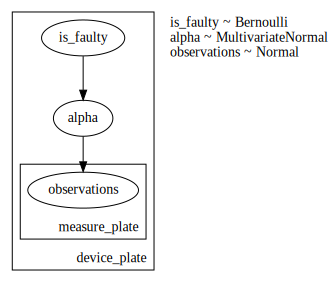

In [5]:
graphical_model

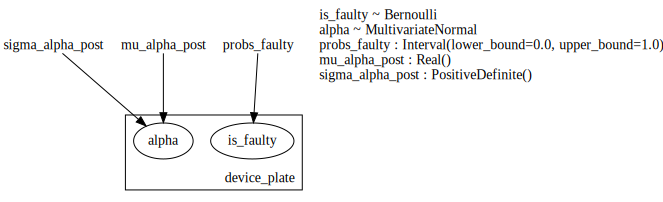

In [6]:
graphical_guide

In [7]:
# iv) Record example outputs of model and guide prior to training
n_model_samples = 10
n_guide_samples = 1000  

predictive = pyro.infer.Predictive
prior_predictive_pretrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_pretrain = predictive(guide, num_samples = n_guide_samples)()['alpha']
posterior_pretrain_faulty = predictive(guide, num_samples = n_guide_samples)()['is_faulty']
posterior_predictive_pretrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


---

# 3. Perform inference

## 🔁 Inference with Discrete Latents

To train the model, we minimize the **Evidence Lower Bound (ELBO)** using stochastic variational inference:

$$
\text{ELBO} = \mathbb{E}_{q_\phi(z)}[\log p(x, z) - \log q_\phi(z)]
$$

Key points:

- Discrete variables are enumerated (i.e., marginalized exactly)
- Continuous variables (like `alpha`) are sampled using Monte Carlo
- We use `TraceEnum_ELBO` with `num_particles > 1` to reduce noise

This allows us to **learn both**:
- The calibration parameters per device
- The likelihood of each device being faulty


In [8]:
"""
    3. Perform inference
"""

# i) Set up inference
# In terms of loss function, we need now TraceEnum_ELBO instead of Trace_ELBO,
# as the latter one is not designed to handle enumeration.
adam = pyro.optim.Adam({"lr": 0.01})
elbo = pyro.infer.TraceEnum_ELBO(num_particles = 20,
                                 max_plate_nesting = 2)
svi = pyro.infer.SVI(model, guide, adam, elbo)

# ii) Perform svi
data = (T_true, T_meas)
loss_sequence = []
for step in range(1000):
    loss = svi.step(*data)
    loss_sequence.append(loss)
    if step %50 == 0:
        print(f'epoch: {step} ; loss : {loss}')
                  
# iii) Record example outputs of model and guide after training
prior_predictive_posttrain = predictive(model, num_samples = n_model_samples)()['observations']
posterior_posttrain = predictive(guide, num_samples = n_guide_samples)()['alpha']
posterior_posttrain_faulty = predictive(guide, num_samples = n_guide_samples)()['is_faulty']
posterior_predictive_posttrain = predictive(model, guide = guide, num_samples = n_model_samples)()['observations']


epoch: 0 ; loss : 75361.66911870714
epoch: 50 ; loss : 21301.113555108397
epoch: 100 ; loss : 15944.434854909268
epoch: 150 ; loss : 14375.678426176944
epoch: 200 ; loss : 10046.695735415042
epoch: 250 ; loss : 5588.02490562984
epoch: 300 ; loss : 6171.284882905331
epoch: 350 ; loss : 4638.8242489165195
epoch: 400 ; loss : 5814.2144417662885
epoch: 450 ; loss : 3476.871366091004
epoch: 500 ; loss : 3193.815687120633
epoch: 550 ; loss : 3173.013873844623
epoch: 600 ; loss : 3021.8902928661346
epoch: 650 ; loss : 2946.462894296896
epoch: 700 ; loss : 3003.7942495757097
epoch: 750 ; loss : 2240.070722070595
epoch: 800 ; loss : 3068.892770083813
epoch: 850 ; loss : 2366.2750901885224
epoch: 900 ; loss : 1826.4464915083586
epoch: 950 ; loss : 2070.3011031269575


## 🔍 Posterior Interpretation

Once training is complete:

- We extract samples of `alpha` from the guide to inspect per-device estimates
- We estimate **posterior probabilities** for `is_faulty` by sampling it repeatedly
- A **higher posterior probability** means a sensor is more likely to be faulty

This can be used to **flag outliers or malfunctioning devices** based on learned probabilistic evidence.


In [9]:
# iv) Additional investigations
model_trace = pyro.poutine.trace(model).get_trace(T_true, observations = T_meas)
guide_trace = pyro.poutine.trace(guide).get_trace(T_true, observations = T_meas)
print('These are the shapes inside of the model : \n {}'.format(model_trace.format_shapes()))
print('These are the shapes inside of the guide : \n {}'.format(guide_trace.format_shapes()))

# The parameters of the posterior are again stored in pyro's param_store
for name, value in pyro.get_param_store().items():
    print('Param : {}; Value : {}'.format(name, value))

# Estimate the posterior probabilities of each device being faulty. 
faulty_pretrain = torch.mean(posterior_pretrain_faulty,dim=0)
faulty_posttrain = torch.mean(posterior_posttrain_faulty,dim=0)
print('is_faulty ground truth : [1, 0, 0, 0, 0]')
print('Probabilities of being faulty pre-training : {} \n'
      'Probabilities of being faulty post-training : {} '
      .format(faulty_pretrain, faulty_posttrain))


These are the shapes inside of the model : 
     Trace Shapes:          
     Param Sites:          
    Sample Sites:          
device_plate dist       |  
            value     5 |  
   is_faulty dist     5 |  
            value     5 |  
       alpha dist     5 | 2
            value     5 | 2
observations dist 5 100 |  
            value 5 100 |  
These are the shapes inside of the guide : 
     Trace Shapes:        
     Param Sites:        
     probs_faulty     5  
    mu_alpha_post   5 2  
 sigma_alpha_post 5 2 2  
    Sample Sites:        
device_plate dist     |  
            value   5 |  
   is_faulty dist   5 |  
            value   5 |  
       alpha dist   5 | 2
            value   5 | 2
Param : probs_faulty; Value : tensor([0.9979, 0.0113, 0.0150, 0.0205, 0.0231], grad_fn=<ClampBackward1>)
Param : mu_alpha_post; Value : tensor([[ 2.3186,  1.0485],
        [-0.0523,  1.0493],
        [-0.1205,  1.0643],
        [-0.1072,  0.9421],
        [-0.1566,  0.9601]], requires_grad

---

# 4. Illustrations and interpretations

We visualize:

- The loss decrease during train
- Raw data alongside generated model outputs
- Posterior samples before and after training
- Estimated latent values (fault probabilities) per device

This provides immediate insight into how well the model fits each sensor and which sensors deviate significantly from expected behavior.


Text(0, 0.5, 'value')

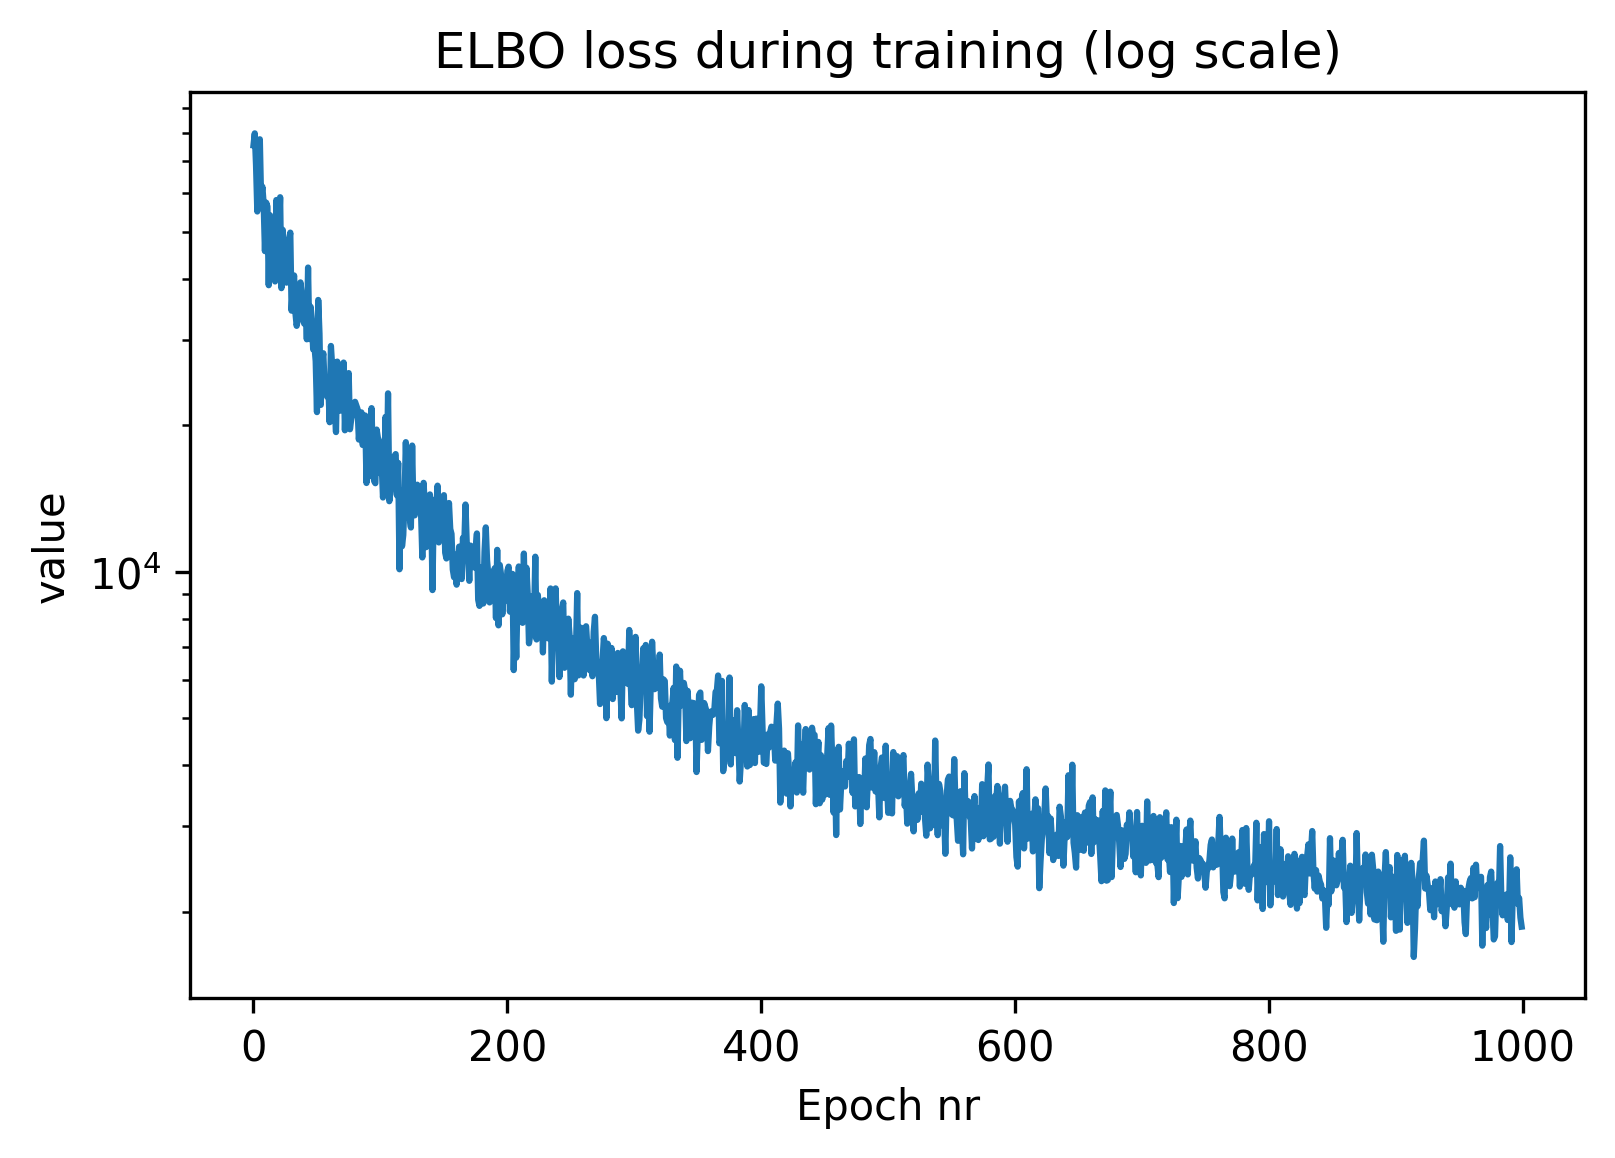

In [10]:
"""
    4. Interpretations and illustrations
"""

# i) Plot and print ELBO loss
plt.figure(1, dpi = 300)
plt.plot(loss_sequence)
plt.yscale("log")
plt.title('ELBO loss during training (log scale)')
plt.xlabel('Epoch nr')
plt.ylabel('value')


In [ ]:

# ii) Compare model output and data

# Create the figure and 2x5 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=False, sharey=False)
# Global y-axis limits
y_min = T_meas.min()
y_max = T_meas.max()

# FIRST ROW
# First plot: measurement data
for i in range(n_device):
    axes[0,0].scatter(T_true[i,:], T_meas[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,0].set_title("Measurement data")
axes[0,0].set_xlabel("T_true")
axes[0,0].set_ylabel("T_meas")
axes[0,0].set_ylim(y_min, y_max)
axes[0,0].legend()

# Second plot: data produced by model pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,1].scatter(T_true[i,:], prior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,1].set_title("Data from model pre-training")
axes[0,1].set_xlabel("T_true")
axes[0,1].set_ylabel("T_meas")
axes[0,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive pre-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[0,2].scatter(T_true[i,:], posterior_predictive_pretrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0,2].set_title("Data from posterior predictive pre-training")
axes[0,2].set_xlabel("T_true")
axes[0,2].set_ylabel("T_meas")
axes[0,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide pre-training
axes[0,3].hist2d(posterior_pretrain[:,:,0].flatten().numpy(),
                 posterior_pretrain[:,:,1].flatten().numpy(),
                 bins=10, cmap='viridis')
axes[0,3].set_title("2D Histogram of parameters pre-train")
axes[0,3].set_xlabel("alpha_0")
axes[0,3].set_ylabel("alpha_1")

# SECOND ROW
# Second plot: data produced by model post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,1].scatter(T_true[i,:], prior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,1].set_title("Data from model post-training")
axes[1,1].set_xlabel("T_true")
axes[1,1].set_ylabel("T_meas")
axes[1,1].set_ylim(y_min, y_max)

# Third plot: data produced by posterior_predictive post-training
for k in range(n_model_samples):
    for i in range(n_device):
        axes[1,2].scatter(T_true[i,:], posterior_predictive_posttrain[k,i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1,2].set_title("Data from posterior predictive post-training")
axes[1,2].set_xlabel("T_true")
axes[1,2].set_ylabel("T_meas")
axes[1,2].set_ylim(y_min, y_max)

# Fourth plot: data produced by guide post-training
axes[1,3].hist2d(posterior_posttrain[:,:,0].flatten().numpy(),
                 posterior_posttrain[:,:,1].flatten().numpy(),
                 bins=10, cmap='viridis')
axes[1,3].set_title("2D Histogram of parameters post-train")
axes[1,3].set_xlabel("alpha_0")
axes[1,3].set_ylabel("alpha_1")

plt.tight_layout()
plt.show()



---

## 🧾 Summary

In this notebook, we:

✅ Built a hierarchical model with **per-device calibration parameters**  
✅ Added a **discrete latent variable** to detect faulty sensors  
✅ Used **enumeration-based inference** to marginalize out `is_faulty`  
✅ Visualized prior/posterior predictive samples and fault probabilities  
✅ Showed that **faulty devices can be identified** automatically via inference


📌 In the next notebook, we’ll go one step further:  
Use **neural networks inside the probabilistic model**, letting us build **deep calibration models** or **learn nonlinear effects**.
